In [1]:
print 'importing modules  '
import os

import subprocess

import datetime
from datetime import datetime as time

import pandas as pd
print pd.__version__


import matplotlib
import matplotlib.pyplot as plt
print matplotlib.__version__

from collections import Counter

import numpy as np
print np.__version__

import seaborn as sns
print sns.__version__

import scipy
import scipy.stats as stats
print scipy.__version__


%matplotlib inline
# magic command for matplotlib figures in the jupyter notebook

importing modules  
0.23.4
2.2.3
1.15.4
0.9.0
1.1.0


## Library indexes

In [2]:
yachie_lib_indexes = './yachie_lab_indexes.csv'
# csv file with the illumina primer indexes

index_seq_dict = {}
# dict with format    index_no : DNA_sequence 

with open(yachie_lib_indexes, 'r') as source:
    for line in source:
        # open file and loop through the lines
        
        line = line.strip('\n').strip('Index_')
        line = line.split(',')
        # format line and split data for dict entry
        
        index_number = line[0]
        # stores index number
        index_seq = line[1]
        # stores index DNA sequence
        
        index_seq_dict[index_number] = index_seq
        # adds index entry to the dict
       

## library:index mappers

In [3]:
index_to_library_mapping = './run_library_indexes_revised.csv'


lib_index_tuble_dict = {}
# dict with the sample name as a key to recover the index pair associated with it
lib_index_by_tuple = {}
# dict with the index pair as a key to recover the sample associated with it


with open(index_to_library_mapping, 'r') as source:
    next(source)
    for line in source:
        # opens file, skips header, and then cycle through the file
        
        line = line.strip('\n')
        line = line.split(',')
        # format line and split it to recover data
        
        lib_name = line[0]
        # sample name
        
        P1 = line[1]
        # forward index id (P1 index)
        P2 = line[2]
        # reverse index id (P2 index)

        
        lib_tuple = tuple((P1,P2))
        # a tuple made by combining the two ids (so it can be used as a key in dict)
        
        lib_index_tuble_dict[lib_name] = lib_tuple
        # enters sample:index_tuple info in the dict
        lib_index_by_tuple[lib_tuple] = lib_name
        # enters index_tuple:sample info in the dict

    

See the R&D notebook in the folder to see how the bowtie indexes were generated

## Getting a list of all the guides

In [4]:
guide_list = []

guide_table = './chip_table_with_muts.tsv'

with open(guide_table, 'r') as source:

    next(source)

    for line in source:

        line_data = line.split('\t')

        guide_name = line_data[1]
        
        guide_list.append(guide_name)
        
print len(guide_list)

39978


In [148]:
file_list = ['01','02','03','04','05','06','07','08','09'] + [str(x) for x in range(10,42)]
# list of sub sequencing files ouputted by the Hiseq

gz_suffix = '.fastq.gz'
# suffix for fastq files compressed with gzip

fastq_suffix = '.fastq'
# suffix for fastq sequence files (the ouput of the illumina HiSEQ)

compressed_file_name_for = './Sample_Yachielab_2_Philippe/Yachielab_2_Philippe_NoIndex_L002_R1_0'
compressed_file_name_rev = './Sample_Yachielab_2_Philippe/Yachielab_2_Philippe_NoIndex_L002_R2_0'
# Universal filename for the forward (R1) and reverse (R2) fastq files


guide_counts_counter_dict = {}
# a dict that will hold one instance of a Counter() object for each library in the experiment (20 total). Each of
# those Counter objects will be used the count the number of reads for each guide in each library based the bowtie
# alignment data

guide_counts_counter_dict_v1 = {}
# a dict that will hold one instance of a Counter() object for each library in the experiment (20 total). Each of
# those Counter objects will be used the count the number of reads for each guide in each library based the bowtie
# alignment data. This one is for the alignment with one mismatch allowed

guide_mismatch_dict = {}



for lib in lib_index_tuble_dict.keys():
    # loops through the samples in the experiment
    
    guide_counts_counter_dict[lib] = Counter()
    guide_counts_counter_dict_v1[lib] = Counter()
    # creates an empty Counter() for guide count
    
    guide_mismatch_dict[lib] = {}
    
    for guide in guide_list:
    
        guide_mismatch_dict[lib][guide] = []
    
    
    
# MUST be reset everytime the analysis script is run


def unpack_and_count(pack_number):
    # This function takes in a subpack number and then performs the following operations:
    #
    #     - Extracts the forward (R1) and reverse (R2) fastq files to a temporary directory
    #     - Aligns part of the forward reads to the forward barcode Bowtie index
    #     - Aligns part of the reverse reads to the reverse barcode Bowtie index
    #     - Aligns part of the read to the gRNA Bowtie index
    #     - Then, using the alignment results, reads with valid P1 and P2 indexes and correct gRNA sequence are used 
    #       to assign gRNA read events to the appropriate sample by inceasing the counter associated with the 
    #       specific guide by 1. THIS REQUIRES THE guide_counts_counter_dict OBJECT, AND IS WHY IT MUST BE RESET EACH
    #       TIME.
    #     - Once this is done, the decompressed fastq files and Bowtie alignments files are removed from the
    #       temporary directory to save up disk space
    #
    # Info on the time taken at each steps and performance is kept in the log directory, which is returned after 
    # function execution.
    
    
    log_entry = {}
    # a dict that will store data on the processing of each sub pack of reads
    
    print time.now()
    log_entry['time_start'] = time.now()
    # print time at start of each pack and store it in log
    
    temp_file_for = './temp_files/temp_' + pack_number + '_R1' + fastq_suffix
    temp_file_rev = './temp_files/temp_' + pack_number + '_R2' + fastq_suffix
    # creates file path for decompressed fastq files
   
    uncompress_for_call = 'zcat ' + compressed_file_name_for + pack_number + gz_suffix + ' > ' + temp_file_for
    uncompress_rev_call = 'zcat ' + compressed_file_name_rev + pack_number + gz_suffix + ' > ' + temp_file_rev
    # creates bash calls (as strings) that will decompress the fastq files
    
    subprocess.check_output(uncompress_for_call, shell=True)
    subprocess.check_output(uncompress_rev_call, shell=True)
    # decompress the forward ans reverse fastq files
    
    
    index_for_align_param = 'bowtie -t -v 1 -p 6 -k 1 --trim3 135 --trim5 6 --norc hiseq_june2018_for_indexes '
    # parameters for forward index alignments. Based on optimization work done in BAR-SEQ notebook
    index_for_align_output = './temp_files/index_for_' + pack_number + '.txt'
    # alignment output filepath as string
    index_for_align_call = index_for_align_param + temp_file_for + ' ' + index_for_align_output
    # alignement call as a string
    subprocess.check_output(index_for_align_call, shell = True)
    # performs the alignment
    
    
    index_rev_align_param = 'bowtie -t -v 1 -p 6 -k 1 --trim3 136 --trim5 6 --nofw hiseq_june2018_rev_indexes '
    # parameters for reverse index alignments. Based on optimization work done in BAR-SEQ notebook
    index_rev_align_output = './temp_files/index_rev_' + pack_number + '.txt'
    # alignment output filepath as string
    index_rev_align_call = index_rev_align_param + temp_file_rev + ' ' + index_rev_align_output
    # alignement call as a string
    subprocess.check_output(index_rev_align_call, shell = True)
    # performs the alignment

    
    guide_align_paramv0 = 'bowtie -t -v 0 -p 6 -k 1 --trim3 47 --trim5 79 --norc -m 1 hiseq_june2018_guides_only '
    # parameters for perfect guide alignments. Based on optimization work done in BAR-SEQ notebook
    guide_align_outputv0 = './temp_files/guidesv0_' + pack_number + '.txt'
    # alignment output filepath as string
    guide_align_callv0 = guide_align_paramv0 + temp_file_for + ' ' + guide_align_outputv0
    # alignement call as a string
    subprocess.check_output(guide_align_callv0, shell = True)
    # performs the alignment

    
    guide_align_paramv1 = 'bowtie -t -v 1 -p 6 -k 1 --trim3 47 --trim5 79 --norc -m 1 hiseq_june2018_guides_only '
    # parameters for 1-mismatch guide alignments. Based on optimization work done in BAR-SEQ notebook
    guide_align_outputv1 = './temp_files/guidesv1_' + pack_number + '.txt'
    # alignment output filepath as string
    guide_align_callv1 = guide_align_paramv1 + temp_file_for + ' ' + guide_align_outputv1
    # alignement call as a string
    subprocess.check_output(guide_align_callv1, shell = True)
    # performs the alignment

        
    log_entry['time_align'] = time.now()
    # adds the time spent aligning sequences to the log
    
    index_found_for = {}
    index_found_rev = {}
    # empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
    # had valid alignments
    

    with open(index_for_align_output, 'r') as for_index_positives:
        for line in for_index_positives:
            # opens P1 index alignment pack file and loops through lines

            line = line.split('\t')
            # split line to extract data
            read_name = line[0].split(' ')[0]
            # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
            # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
            #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
            # For info on illumina read name convention
            index_found_for[read_name] = line[2]
            # add read P1 index to dict
            
    log_entry['for_index_pos'] = len(index_found_for.keys())
    # log entry: number of reads with valid P1 index alignments

    with open(index_rev_align_output, 'r') as rev_index_positives:
        for line in rev_index_positives:
            # opens P2 index alignment pack file and loops through lines

            line = line.split('\t')
            # split line to extract data
            read_name = line[0].split(' ')[0]
            # Only keep the cluster coordinates and run associated info
            index_found_rev[read_name] = line[2]
            # add read P2 index to dict
            
    log_entry['rev_index_pos'] = len(index_found_rev.keys())
    # log entry: number of reads with valid P2 index alignments


    both_indexes = list(set(index_found_for.keys()) & set(index_found_rev.keys()))
    log_entry['both_index'] = len(both_indexes)
    # Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
    # taht number for the read pack in the log


    guide_match_v0 = {}
    # empty containers that will hold    read_name: guide    data pairs for the forward reads that had alignments
    # with 0 mismatches at the right location in the reference sequence set

    with open(guide_align_outputv0, 'r') as perfect_matches:
        for line in perfect_matches:
            # opens gRNA alignment pack file and loops through lines

            line = line.split('\t')
            # split line to extract data
            read_name = line[0].split(' ')[0]
            # Only keep the cluster coordinates and run associated info
            guide = line[2]
            # the guide for which a match was found
            
            if int(line[3]) in range(31, 38):
                # the alignment is at the right location in the guide sequence

                guide_match_v0[read_name] = guide
                # add read:guide to dict
            
    log_entry['perfect_matches'] = len(guide_match_v0.keys())
    # adds the number of perfect matches found in the pack of reads
            
        
    guide_match_v1 = {}
    # empty containers that will hold    read_name: guide    data pairs for the forward reads that had alignments
    # with 1 mismatches at most at the right location in the reference sequence set
    
    
    #### Still in progresss
    read_mismatch_guide = {}
    # a dict that will hold the different mismatches found for 
    
    
    with open(guide_align_outputv1, 'r') as v1_matches:

        for line in v1_matches:

            line = line.split('\t')
            read_name = line[0].split(' ')[0]
            guide = line[2]
            
            mismatches = line[7].strip('\n')
            
            if int(line[3]) in range(31, 38):
            
                guide_match_v1[read_name] = guide
                
                if mismatches != '':
                    
                    read_mismatch_guide[read_name] = mismatches
                    
                elif mismatches == '':
                    
                    read_mismatch_guide[read_name] = []
                    
    #### Still in progresss              
                    

    log_entry['v1_matches'] = len(guide_match_v1.keys())
    log_entry['time_parsing'] = time.now()
    # adds the number of perfect and 1 mismatch matches found in the pack of reads and the time spent parsing to the
    # log

    

    indexes_and_guides_v0 = list(set(index_found_for.keys()) & set(index_found_rev.keys()) & set(guide_match_v0.keys()))
    log_entry['full_hits_v0'] = len(indexes_and_guides_v0)
    # uses sets in python to find the set of reads for which the P1, P2 and gRNA alignments were good
    
    indexes_and_guides_v1 = list(set(index_found_for.keys()) & set(index_found_rev.keys()) & set(guide_match_v1.keys()))
    log_entry['full_hits_v1'] = len(indexes_and_guides_v1)
    # uses sets in python to find the set of reads for which the P1, P2 and gRNA alignments (with up to one mismatch)
    # were good

    
    
    for read in indexes_and_guides_v0:
        # loops through the reads tht passed the filter
    
        for_i = index_found_for[read]
        # gets the P1 index of the read

        rev_i = index_found_rev[read]
        # gets the P2 index of the read

        lib = lib_index_by_tuple[tuple((for_i, rev_i))]
        # gets the sample to which the read should be assigned based on P1, P2 combination
        
        guide = guide_match_v0[read]
        # gets the guide associated with the read
        
        guide_counts_counter_dict[lib][guide] += 1
        # a count for the guide detected in its specific sample
        
    for read in indexes_and_guides_v1:
        # loops through the reads tht passed the filter
    
        for_i = index_found_for[read]
        # gets the P1 index of the read

        rev_i = index_found_rev[read]
        # gets the P2 index of the read

        lib = lib_index_by_tuple[tuple((for_i, rev_i))]
        # gets the sample to which the read should be assigned based on P1, P2 combination
        
        guide = guide_match_v1[read]
        # gets the guide associated with the read (one mismatch allowed)
        
        guide_counts_counter_dict_v1[lib][guide] += 1
        # a count for the guide detected in its specific sample
        
        guide_mismatch_dict[lib][guide] += [read_mismatch_guide[read]]
        
    log_entry['read_match_time'] = time.now()
    # add time spent matching up reads to the log
    
    
    cleanup_command = 'rm ./temp_files/*'
    # the cleanup command (empties the temporary directory) in string format
    
    subprocess.check_output(cleanup_command, shell = True)
    # cleans up the temporary directory
    
    log_entry['cleanup'] = time.now()
    # adds time spent cleaning up to the log
    
    
    return log_entry
    # returns the info about the run in a dict format
        
        

    
    
    
    
    
       
unpack_and_count(file_list[0])

2018-08-13 14:31:48.483903


{'both_index': 3365544,
 'cleanup': datetime.datetime(2018, 8, 13, 14, 35, 2, 883078),
 'for_index_pos': 3403899,
 'full_hits_v0': 1622015,
 'full_hits_v1': 2030864,
 'perfect_matches': 1642039,
 'read_match_time': datetime.datetime(2018, 8, 13, 14, 35, 2, 92265),
 'rev_index_pos': 3420892,
 'time_align': datetime.datetime(2018, 8, 13, 14, 33, 35, 244071),
 'time_parsing': datetime.datetime(2018, 8, 13, 14, 34, 44, 248350),
 'time_start': datetime.datetime(2018, 8, 13, 14, 31, 48, 483954),
 'v1_matches': 2056690}

In [149]:
test = {'a':[]}
test['a'] += ['az']
test['a'] += ['by']
test['a']

['az', 'by']

22818
gal_16_B
25009
gal_16_B
25009
        slope          intercept          r_value              p_value                  std_err
(1.2559706609644905, -316.9625822158996, 0.9990257558536061, 7.482241765626027e-26, 0.013077046092178224)
0.998052460859


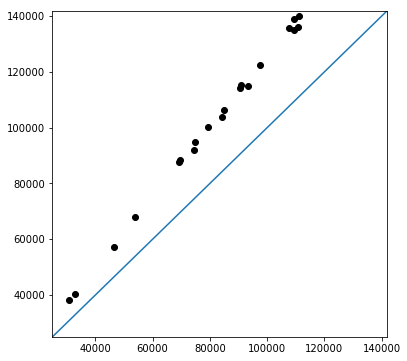

In [150]:
print len(guide_counts_counter_dict[guide_counts_counter_dict.keys()[0]])
print guide_counts_counter_dict.keys()[0]
print len(guide_counts_counter_dict_v1[guide_counts_counter_dict_v1.keys()[0]])
print guide_counts_counter_dict_v1.keys()[0]

tot_len = 0

guide_mismatch_dict['gal_16_B'] = dict((k, v) for k, v in guide_mismatch_dict['gal_16_B'].iteritems() if v != [])

for x in guide_mismatch_dict['gal_16_B'].keys():
    
    if guide_mismatch_dict['gal_16_B'][x] == []:
    
        tot_len += 1
        
print len(guide_mismatch_dict['gal_16_B'].keys())

# missmatch dict size matches the read dict size.

plt.figure(figsize=(6,6))

plt.plot([sum(guide_counts_counter_dict[x].values()) for x in lib_index_tuble_dict.keys()], [sum(guide_counts_counter_dict_v1[x].values()) for x in lib_index_tuble_dict.keys()], 'ko')
plt.xlim(25000, 142000)
plt.ylim(25000, 142000)
plt.plot(range(25000,142000), range(25000,142000))
print '        slope          intercept          r_value              p_value                  std_err'
print scipy.stats.linregress([sum(guide_counts_counter_dict[x].values()) for x in lib_index_tuble_dict.keys()], [sum(guide_counts_counter_dict_v1[x].values()) for x in lib_index_tuble_dict.keys()])
print 0.9990257558536061**2

## On the whole dataset

In [151]:
guide_counts_counter_dict = {}
# a dict that will hold one instance of a Counter() object for each library in the experiment (20 total). Each of
# those Counter objects will be used the count the number of reads for each guide in each library based the bowtie
# alignment data

guide_counts_counter_dict_v1 = {}
# a dict that will hold one instance of a Counter() object for each library in the experiment (20 total). Each of
# those Counter objects will be used the count the number of reads for each guide in each library based the bowtie
# alignment data. This one is for the alignment with one mismatch allowed

guide_mismatch_dict = {}



for lib in lib_index_tuble_dict.keys():
    # loops through the samples in the experiment
    
    guide_counts_counter_dict[lib] = Counter()
    guide_counts_counter_dict_v1[lib] = Counter()
    # creates an empty Counter() for guide count
    
    guide_mismatch_dict[lib] = {}
    
    for guide in guide_list:
    
        guide_mismatch_dict[lib][guide] = []
    
log_table = {}
# the dict of dicts that will hold the different log entries

for pack in file_list:
    # loops through read packs
    
    log_table[pack] = unpack_and_count(pack)
    # performs alignments and counts on each pack, adding the log of the operation to the log dict

2018-08-13 14:35:07.434775
2018-08-13 14:37:36.329835
2018-08-13 14:40:28.701567
2018-08-13 14:43:16.176889
2018-08-13 14:46:06.447553
2018-08-13 14:48:52.124982
2018-08-13 14:51:42.491714
2018-08-13 14:54:26.479659
2018-08-13 14:57:10.930735
2018-08-13 14:59:59.140929
2018-08-13 15:02:39.002841
2018-08-13 15:06:22.177764
2018-08-13 15:09:09.821644
2018-08-13 15:12:00.934234
2018-08-13 15:14:53.470747
2018-08-13 15:17:43.758208
2018-08-13 15:20:25.138248
2018-08-13 15:23:27.649964
2018-08-13 15:26:16.577219
2018-08-13 15:28:55.368717
2018-08-13 15:31:26.553214
2018-08-13 15:34:16.006258
2018-08-13 15:36:59.960405
2018-08-13 15:39:54.443431
2018-08-13 15:42:33.601808
2018-08-13 15:46:12.999871
2018-08-13 15:48:54.186424
2018-08-13 15:51:39.106483
2018-08-13 15:54:21.263905
2018-08-13 15:56:58.314829
2018-08-13 15:59:52.918178
2018-08-13 16:02:36.840788
2018-08-13 16:10:11.738084
2018-08-13 16:22:53.253407
2018-08-13 16:26:19.655274
2018-08-13 16:29:13.624433
2018-08-13 16:32:05.048818
2

## save dict as pickle

In [152]:
import pickle

guide_counts_counter_dict_save = './guide_counts_counter_dict_save.p'
guide_counts_counter_dict_v1_save = './guide_counts_counter_dict_v1_save.p'
guide_mismatch_dict_save = './guide_mismatch_dict_save.p'

pickle.dump(guide_counts_counter_dict, open(guide_counts_counter_dict_save, 'wb'))
pickle.dump(guide_counts_counter_dict_v1, open(guide_counts_counter_dict_v1_save, 'wb'))
pickle.dump(guide_mismatch_dict, open(guide_mismatch_dict_save, 'wb'))




In [5]:
import pickle

guide_counts_counter_dict_save = './guide_counts_counter_dict_save.p'
guide_counts_counter_dict_v1_save = './guide_counts_counter_dict_v1_save.p'
guide_mismatch_dict_save = './guide_mismatch_dict_save.p'


guide_counts_counter_dict = pickle.load( open(guide_counts_counter_dict_save, 'rb') )
guide_counts_counter_dict_v1 = pickle.load( open(guide_counts_counter_dict_v1_save, 'rb') )
guide_mismatch_dict = pickle.load( open(guide_mismatch_dict_save, 'rb') )

## Visualize log

In [23]:
log_from_out = {'30': {'v1_matches': 2030720, 'time_start': datetime.datetime(2018, 6, 28, 17, 47, 29, 338416), 'full_hits_v1': 2004229, 'full_hits_v0': 1599386, 'time_align': datetime.datetime(2018, 6, 28, 17, 49, 21, 964033), 'for_index_pos': 3377380, 'cleanup': datetime.datetime(2018, 6, 28, 17, 49, 47, 289375), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 49, 46, 999910), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 49, 35, 686351), 'rev_index_pos': 3395156, 'perfect_matches': 1619112, 'both_index': 3329935}, '02': {'v1_matches': 2053328, 'time_start': datetime.datetime(2018, 6, 28, 16, 47, 36, 196129), 'full_hits_v1': 2026937, 'full_hits_v0': 1619543, 'time_align': datetime.datetime(2018, 6, 28, 16, 48, 43, 209041), 'for_index_pos': 3400107, 'cleanup': datetime.datetime(2018, 6, 28, 16, 49, 8, 991611), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 49, 8, 699349), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 48, 57, 505179), 'rev_index_pos': 3416063, 'perfect_matches': 1639806, 'both_index': 3359372}, '03': {'v1_matches': 2045445, 'time_start': datetime.datetime(2018, 6, 28, 16, 49, 10, 607243), 'full_hits_v1': 2018590, 'full_hits_v0': 1611704, 'time_align': datetime.datetime(2018, 6, 28, 16, 50, 17, 671956), 'for_index_pos': 3392925, 'cleanup': datetime.datetime(2018, 6, 28, 16, 50, 43, 921272), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 50, 43, 631630), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 50, 32, 144629), 'rev_index_pos': 3410532, 'perfect_matches': 1632228, 'both_index': 3350232}, '26': {'v1_matches': 2027284, 'time_start': datetime.datetime(2018, 6, 28, 17, 38, 10, 558365), 'full_hits_v1': 2000735, 'full_hits_v0': 1567526, 'time_align': datetime.datetime(2018, 6, 28, 17, 40, 2, 602272), 'for_index_pos': 3375345, 'cleanup': datetime.datetime(2018, 6, 28, 17, 40, 29, 552761), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 40, 29, 251151), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 40, 17, 454708), 'rev_index_pos': 3396852, 'perfect_matches': 1587261, 'both_index': 3331667}, '01': {'v1_matches': 2056690, 'time_start': datetime.datetime(2018, 6, 28, 16, 46, 0, 110991), 'full_hits_v1': 2030864, 'full_hits_v0': 1622015, 'time_align': datetime.datetime(2018, 6, 28, 16, 47, 8, 432915), 'for_index_pos': 3403899, 'cleanup': datetime.datetime(2018, 6, 28, 16, 47, 34, 605495), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 47, 34, 194521), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 47, 22, 702401), 'rev_index_pos': 3420892, 'perfect_matches': 1642039, 'both_index': 3365544}, '06': {'v1_matches': 2046340, 'time_start': datetime.datetime(2018, 6, 28, 16, 53, 56, 250082), 'full_hits_v1': 2019126, 'full_hits_v0': 1612016, 'time_align': datetime.datetime(2018, 6, 28, 16, 55, 17, 761151), 'for_index_pos': 3397562, 'cleanup': datetime.datetime(2018, 6, 28, 16, 55, 43, 433054), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 55, 43, 159572), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 55, 32, 13405), 'rev_index_pos': 3412666, 'perfect_matches': 1632682, 'both_index': 3353669}, '07': {'v1_matches': 2043604, 'time_start': datetime.datetime(2018, 6, 28, 16, 55, 45, 46970), 'full_hits_v1': 2017098, 'full_hits_v0': 1608597, 'time_align': datetime.datetime(2018, 6, 28, 16, 57, 4, 527641), 'for_index_pos': 3391839, 'cleanup': datetime.datetime(2018, 6, 28, 16, 57, 29, 698403), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 57, 29, 429121), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 57, 18, 595587), 'rev_index_pos': 3405445, 'perfect_matches': 1628686, 'both_index': 3346599}, '04': {'v1_matches': 2050010, 'time_start': datetime.datetime(2018, 6, 28, 16, 50, 45, 524584), 'full_hits_v1': 2022931, 'full_hits_v0': 1614417, 'time_align': datetime.datetime(2018, 6, 28, 16, 51, 54, 68103), 'for_index_pos': 3397336, 'cleanup': datetime.datetime(2018, 6, 28, 16, 52, 19, 923439), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 52, 19, 630520), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 52, 8, 411750), 'rev_index_pos': 3416433, 'perfect_matches': 1634968, 'both_index': 3355536}, '05': {'v1_matches': 2044372, 'time_start': datetime.datetime(2018, 6, 28, 16, 52, 21, 550052), 'full_hits_v1': 2017963, 'full_hits_v0': 1611873, 'time_align': datetime.datetime(2018, 6, 28, 16, 53, 28, 980426), 'for_index_pos': 3393471, 'cleanup': datetime.datetime(2018, 6, 28, 16, 53, 54, 631456), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 53, 54, 338111), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 53, 43, 180235), 'rev_index_pos': 3409132, 'perfect_matches': 1631891, 'both_index': 3349952}, '08': {'v1_matches': 2030335, 'time_start': datetime.datetime(2018, 6, 28, 16, 57, 31, 266411), 'full_hits_v1': 2003611, 'full_hits_v0': 1596499, 'time_align': datetime.datetime(2018, 6, 28, 16, 58, 51, 37890), 'for_index_pos': 3382741, 'cleanup': datetime.datetime(2018, 6, 28, 16, 59, 16, 902786), 'read_match_time': datetime.datetime(2018, 6, 28, 16, 59, 16, 643397), 'time_parsing': datetime.datetime(2018, 6, 28, 16, 59, 5, 432346), 'rev_index_pos': 3412521, 'perfect_matches': 1616461, 'both_index': 3337498}, '09': {'v1_matches': 2041511, 'time_start': datetime.datetime(2018, 6, 28, 16, 59, 18, 450237), 'full_hits_v1': 2015597, 'full_hits_v0': 1607274, 'time_align': datetime.datetime(2018, 6, 28, 17, 0, 50, 51107), 'for_index_pos': 3398728, 'cleanup': datetime.datetime(2018, 6, 28, 17, 1, 17, 243109), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 1, 16, 986994), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 1, 4, 660074), 'rev_index_pos': 3408998, 'perfect_matches': 1626808, 'both_index': 3352845}, '28': {'v1_matches': 2027955, 'time_start': datetime.datetime(2018, 6, 28, 17, 42, 49, 726322), 'full_hits_v1': 2001106, 'full_hits_v0': 1597814, 'time_align': datetime.datetime(2018, 6, 28, 17, 44, 41, 664146), 'for_index_pos': 3373607, 'cleanup': datetime.datetime(2018, 6, 28, 17, 45, 7, 233095), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 45, 6, 921135), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 44, 55, 233184), 'rev_index_pos': 3393235, 'perfect_matches': 1617992, 'both_index': 3327324}, '29': {'v1_matches': 2036592, 'time_start': datetime.datetime(2018, 6, 28, 17, 45, 8, 866273), 'full_hits_v1': 2009224, 'full_hits_v0': 1604216, 'time_align': datetime.datetime(2018, 6, 28, 17, 47, 2, 414671), 'for_index_pos': 3381312, 'cleanup': datetime.datetime(2018, 6, 28, 17, 47, 27, 789067), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 47, 27, 490176), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 47, 16, 132454), 'rev_index_pos': 3400135, 'perfect_matches': 1624677, 'both_index': 3335467}, '40': {'v1_matches': 2036056, 'time_start': datetime.datetime(2018, 6, 28, 18, 10, 37, 753649), 'full_hits_v1': 2008053, 'full_hits_v0': 1603119, 'time_align': datetime.datetime(2018, 6, 28, 18, 12, 34, 55041), 'for_index_pos': 3380975, 'cleanup': datetime.datetime(2018, 6, 28, 18, 13, 0, 81376), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 12, 59, 791143), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 12, 47, 897800), 'rev_index_pos': 3413100, 'perfect_matches': 1623694, 'both_index': 3336487}, '41': {'v1_matches': 1911295, 'time_start': datetime.datetime(2018, 6, 28, 18, 13, 1, 715860), 'full_hits_v1': 1883918, 'full_hits_v0': 1501994, 'time_align': datetime.datetime(2018, 6, 28, 18, 14, 41, 607856), 'for_index_pos': 3182774, 'cleanup': datetime.datetime(2018, 6, 28, 18, 15, 8, 805775), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 15, 8, 426196), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 14, 57, 184236), 'rev_index_pos': 3215013, 'perfect_matches': 1521830, 'both_index': 3138800}, '14': {'v1_matches': 2051421, 'time_start': datetime.datetime(2018, 6, 28, 17, 9, 48, 226103), 'full_hits_v1': 2024120, 'full_hits_v0': 1616603, 'time_align': datetime.datetime(2018, 6, 28, 17, 11, 23, 136396), 'for_index_pos': 3399523, 'cleanup': datetime.datetime(2018, 6, 28, 17, 11, 48, 806216), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 11, 48, 556491), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 11, 36, 689943), 'rev_index_pos': 3422354, 'perfect_matches': 1637376, 'both_index': 3358062}, '24': {'v1_matches': 2021627, 'time_start': datetime.datetime(2018, 6, 28, 17, 33, 39, 457352), 'full_hits_v1': 1994507, 'full_hits_v0': 1560606, 'time_align': datetime.datetime(2018, 6, 28, 17, 35, 29, 616094), 'for_index_pos': 3381816, 'cleanup': datetime.datetime(2018, 6, 28, 17, 35, 54, 630671), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 35, 54, 349940), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 35, 43, 104252), 'rev_index_pos': 3406762, 'perfect_matches': 1580710, 'both_index': 3339123}, '25': {'v1_matches': 1848318, 'time_start': datetime.datetime(2018, 6, 28, 17, 35, 56, 198213), 'full_hits_v1': 1823108, 'full_hits_v0': 1247090, 'time_align': datetime.datetime(2018, 6, 28, 17, 37, 45, 999634), 'for_index_pos': 3376094, 'cleanup': datetime.datetime(2018, 6, 28, 17, 38, 9, 25080), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 38, 8, 745133), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 37, 58, 718033), 'rev_index_pos': 3396960, 'perfect_matches': 1263600, 'both_index': 3330984}, '39': {'v1_matches': 2030920, 'time_start': datetime.datetime(2018, 6, 28, 18, 8, 14, 538508), 'full_hits_v1': 2003212, 'full_hits_v0': 1599000, 'time_align': datetime.datetime(2018, 6, 28, 18, 10, 9, 973483), 'for_index_pos': 3371427, 'cleanup': datetime.datetime(2018, 6, 28, 18, 10, 36, 109056), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 10, 35, 796609), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 10, 23, 795064), 'rev_index_pos': 3402444, 'perfect_matches': 1619708, 'both_index': 3327439}, '27': {'v1_matches': 2039123, 'time_start': datetime.datetime(2018, 6, 28, 17, 40, 31, 171318), 'full_hits_v1': 2011987, 'full_hits_v0': 1606879, 'time_align': datetime.datetime(2018, 6, 28, 17, 42, 23, 320184), 'for_index_pos': 3382060, 'cleanup': datetime.datetime(2018, 6, 28, 17, 42, 48, 185740), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 42, 47, 870780), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 42, 36, 698556), 'rev_index_pos': 3404308, 'perfect_matches': 1627253, 'both_index': 3338784}, '20': {'v1_matches': 2047652, 'time_start': datetime.datetime(2018, 6, 28, 17, 24, 13, 603222), 'full_hits_v1': 2020797, 'full_hits_v0': 1610839, 'time_align': datetime.datetime(2018, 6, 28, 17, 25, 59, 136658), 'for_index_pos': 3409217, 'cleanup': datetime.datetime(2018, 6, 28, 17, 26, 24, 461087), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 26, 24, 83444), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 26, 12, 703374), 'rev_index_pos': 3423200, 'perfect_matches': 1630999, 'both_index': 3364032}, '38': {'v1_matches': 2027153, 'time_start': datetime.datetime(2018, 6, 28, 18, 5, 53, 545594), 'full_hits_v1': 1999077, 'full_hits_v0': 1573749, 'time_align': datetime.datetime(2018, 6, 28, 18, 7, 48, 35050), 'for_index_pos': 3373912, 'cleanup': datetime.datetime(2018, 6, 28, 18, 8, 12, 914430), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 8, 12, 619303), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 8, 1, 502219), 'rev_index_pos': 3408596, 'perfect_matches': 1594155, 'both_index': 3330026}, '21': {'v1_matches': 2048229, 'time_start': datetime.datetime(2018, 6, 28, 17, 26, 26, 12204), 'full_hits_v1': 2021005, 'full_hits_v0': 1610922, 'time_align': datetime.datetime(2018, 6, 28, 17, 28, 21, 880311), 'for_index_pos': 3405648, 'cleanup': datetime.datetime(2018, 6, 28, 17, 28, 47, 623545), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 28, 47, 334869), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 28, 35, 607438), 'rev_index_pos': 3426547, 'perfect_matches': 1631193, 'both_index': 3362847}, '11': {'v1_matches': 2047769, 'time_start': datetime.datetime(2018, 6, 28, 17, 3, 45, 971605), 'full_hits_v1': 2020153, 'full_hits_v0': 1613158, 'time_align': datetime.datetime(2018, 6, 28, 17, 5, 11, 911091), 'for_index_pos': 3398293, 'cleanup': datetime.datetime(2018, 6, 28, 17, 5, 38, 546724), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 5, 38, 266553), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 5, 26, 534528), 'rev_index_pos': 3420259, 'perfect_matches': 1634022, 'both_index': 3355345}, '10': {'v1_matches': 2045366, 'time_start': datetime.datetime(2018, 6, 28, 17, 1, 18, 807093), 'full_hits_v1': 2019105, 'full_hits_v0': 1609497, 'time_align': datetime.datetime(2018, 6, 28, 17, 3, 17, 714842), 'for_index_pos': 3410373, 'cleanup': datetime.datetime(2018, 6, 28, 17, 3, 44, 344628), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 3, 43, 972501), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 3, 31, 934200), 'rev_index_pos': 3422296, 'perfect_matches': 1629068, 'both_index': 3364397}, '13': {'v1_matches': 2052630, 'time_start': datetime.datetime(2018, 6, 28, 17, 7, 27, 314658), 'full_hits_v1': 2025274, 'full_hits_v0': 1617825, 'time_align': datetime.datetime(2018, 6, 28, 17, 9, 20, 360534), 'for_index_pos': 3401811, 'cleanup': datetime.datetime(2018, 6, 28, 17, 9, 46, 523816), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 9, 46, 234072), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 9, 34, 74053), 'rev_index_pos': 3424754, 'perfect_matches': 1638689, 'both_index': 3360560}, '12': {'v1_matches': 2060197, 'time_start': datetime.datetime(2018, 6, 28, 17, 5, 40, 119548), 'full_hits_v1': 2033796, 'full_hits_v0': 1625369, 'time_align': datetime.datetime(2018, 6, 28, 17, 6, 59, 976136), 'for_index_pos': 3408387, 'cleanup': datetime.datetime(2018, 6, 28, 17, 7, 25, 735849), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 7, 25, 427410), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 7, 14, 123972), 'rev_index_pos': 3431031, 'perfect_matches': 1645683, 'both_index': 3369423}, '15': {'v1_matches': 2054465, 'time_start': datetime.datetime(2018, 6, 28, 17, 11, 50, 423930), 'full_hits_v1': 2027446, 'full_hits_v0': 1619215, 'time_align': datetime.datetime(2018, 6, 28, 17, 14, 0, 282947), 'for_index_pos': 3405489, 'cleanup': datetime.datetime(2018, 6, 28, 17, 14, 24, 686932), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 14, 24, 404234), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 14, 13, 823001), 'rev_index_pos': 3427539, 'perfect_matches': 1639664, 'both_index': 3364674}, '22': {'v1_matches': 2046852, 'time_start': datetime.datetime(2018, 6, 28, 17, 28, 49, 271749), 'full_hits_v1': 2020568, 'full_hits_v0': 1616163, 'time_align': datetime.datetime(2018, 6, 28, 17, 30, 48, 316808), 'for_index_pos': 3386397, 'cleanup': datetime.datetime(2018, 6, 28, 17, 31, 13, 503686), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 31, 13, 204437), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 31, 1, 834501), 'rev_index_pos': 3407999, 'perfect_matches': 1636370, 'both_index': 3346554}, '17': {'v1_matches': 2054766, 'time_start': datetime.datetime(2018, 6, 28, 17, 17, 1, 274600), 'full_hits_v1': 2027940, 'full_hits_v0': 1618154, 'time_align': datetime.datetime(2018, 6, 28, 17, 18, 59, 827736), 'for_index_pos': 3407494, 'cleanup': datetime.datetime(2018, 6, 28, 17, 19, 25, 630998), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 19, 25, 351312), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 19, 13, 482286), 'rev_index_pos': 3426024, 'perfect_matches': 1638319, 'both_index': 3365206}, '16': {'v1_matches': 2050596, 'time_start': datetime.datetime(2018, 6, 28, 17, 14, 26, 242879), 'full_hits_v1': 2023520, 'full_hits_v0': 1614939, 'time_align': datetime.datetime(2018, 6, 28, 17, 16, 34, 448941), 'for_index_pos': 3400716, 'cleanup': datetime.datetime(2018, 6, 28, 17, 16, 59, 643441), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 16, 59, 367260), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 16, 48, 9930), 'rev_index_pos': 3420240, 'perfect_matches': 1635422, 'both_index': 3357910}, '19': {'v1_matches': 2052304, 'time_start': datetime.datetime(2018, 6, 28, 17, 21, 49, 787238), 'full_hits_v1': 2025984, 'full_hits_v0': 1615339, 'time_align': datetime.datetime(2018, 6, 28, 17, 23, 46, 199518), 'for_index_pos': 3413446, 'cleanup': datetime.datetime(2018, 6, 28, 17, 24, 11, 973267), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 24, 11, 680450), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 24, 0, 87494), 'rev_index_pos': 3428440, 'perfect_matches': 1635103, 'both_index': 3370322}, '18': {'v1_matches': 2041348, 'time_start': datetime.datetime(2018, 6, 28, 17, 19, 27, 255786), 'full_hits_v1': 2014182, 'full_hits_v0': 1606333, 'time_align': datetime.datetime(2018, 6, 28, 17, 21, 22, 888963), 'for_index_pos': 3394726, 'cleanup': datetime.datetime(2018, 6, 28, 17, 21, 48, 146326), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 21, 47, 875409), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 21, 36, 392351), 'rev_index_pos': 3416058, 'perfect_matches': 1626681, 'both_index': 3349959}, '31': {'v1_matches': 2034355, 'time_start': datetime.datetime(2018, 6, 28, 17, 49, 48, 922145), 'full_hits_v1': 2006426, 'full_hits_v0': 1600179, 'time_align': datetime.datetime(2018, 6, 28, 17, 51, 43, 716159), 'for_index_pos': 3382097, 'cleanup': datetime.datetime(2018, 6, 28, 17, 52, 9, 260397), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 52, 8, 974836), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 51, 57, 488854), 'rev_index_pos': 3409516, 'perfect_matches': 1620653, 'both_index': 3336602}, '23': {'v1_matches': 2040384, 'time_start': datetime.datetime(2018, 6, 28, 17, 31, 15, 145965), 'full_hits_v1': 2013163, 'full_hits_v0': 1608744, 'time_align': datetime.datetime(2018, 6, 28, 17, 33, 12, 846647), 'for_index_pos': 3381125, 'cleanup': datetime.datetime(2018, 6, 28, 17, 33, 37, 916713), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 33, 37, 638410), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 33, 26, 313599), 'rev_index_pos': 3403943, 'perfect_matches': 1629562, 'both_index': 3339037}, '37': {'v1_matches': 2029839, 'time_start': datetime.datetime(2018, 6, 28, 18, 3, 31, 244879), 'full_hits_v1': 1999299, 'full_hits_v0': 1594417, 'time_align': datetime.datetime(2018, 6, 28, 18, 5, 26, 436198), 'for_index_pos': 3369984, 'cleanup': datetime.datetime(2018, 6, 28, 18, 5, 51, 999189), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 5, 51, 736240), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 5, 40, 170027), 'rev_index_pos': 3399654, 'perfect_matches': 1616699, 'both_index': 3321765}, '36': {'v1_matches': 2039007, 'time_start': datetime.datetime(2018, 6, 28, 18, 1, 8, 341970), 'full_hits_v1': 2011325, 'full_hits_v0': 1606704, 'time_align': datetime.datetime(2018, 6, 28, 18, 3, 4, 446692), 'for_index_pos': 3375992, 'cleanup': datetime.datetime(2018, 6, 28, 18, 3, 29, 686891), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 3, 29, 405335), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 3, 18, 225605), 'rev_index_pos': 3414141, 'perfect_matches': 1627500, 'both_index': 3335504}, '35': {'v1_matches': 2035288, 'time_start': datetime.datetime(2018, 6, 28, 17, 58, 48, 492981), 'full_hits_v1': 2007286, 'full_hits_v0': 1604579, 'time_align': datetime.datetime(2018, 6, 28, 18, 0, 41, 359622), 'for_index_pos': 3369439, 'cleanup': datetime.datetime(2018, 6, 28, 18, 1, 6, 700334), 'read_match_time': datetime.datetime(2018, 6, 28, 18, 1, 6, 404635), 'time_parsing': datetime.datetime(2018, 6, 28, 18, 0, 54, 935862), 'rev_index_pos': 3407488, 'perfect_matches': 1625626, 'both_index': 3328307}, '34': {'v1_matches': 2036294, 'time_start': datetime.datetime(2018, 6, 28, 17, 56, 29, 101415), 'full_hits_v1': 2008472, 'full_hits_v0': 1605164, 'time_align': datetime.datetime(2018, 6, 28, 17, 58, 21, 239152), 'for_index_pos': 3371945, 'cleanup': datetime.datetime(2018, 6, 28, 17, 58, 46, 867662), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 58, 46, 584796), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 58, 34, 886160), 'rev_index_pos': 3410709, 'perfect_matches': 1626216, 'both_index': 3330880}, '33': {'v1_matches': 2045332, 'time_start': datetime.datetime(2018, 6, 28, 17, 54, 6, 628171), 'full_hits_v1': 2018468, 'full_hits_v0': 1613873, 'time_align': datetime.datetime(2018, 6, 28, 17, 56, 2, 196915), 'for_index_pos': 3382629, 'cleanup': datetime.datetime(2018, 6, 28, 17, 56, 27, 515665), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 56, 27, 233880), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 56, 15, 806739), 'rev_index_pos': 3420974, 'perfect_matches': 1634173, 'both_index': 3343746}, '32': {'v1_matches': 2044161, 'time_start': datetime.datetime(2018, 6, 28, 17, 52, 10, 825139), 'full_hits_v1': 2016965, 'full_hits_v0': 1612441, 'time_align': datetime.datetime(2018, 6, 28, 17, 53, 40, 62030), 'for_index_pos': 3379044, 'cleanup': datetime.datetime(2018, 6, 28, 17, 54, 5, 50199), 'read_match_time': datetime.datetime(2018, 6, 28, 17, 54, 4, 786606), 'time_parsing': datetime.datetime(2018, 6, 28, 17, 53, 53, 576948), 'rev_index_pos': 3416047, 'perfect_matches': 1633138, 'both_index': 3339566}}

65405774 82297167


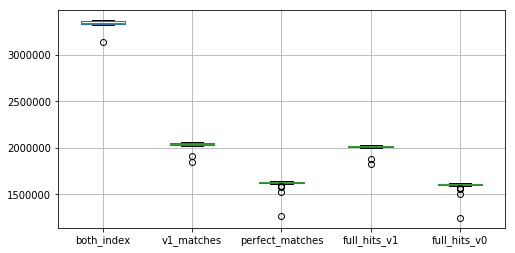

In [24]:
log_table_from_out = pd.DataFrame.from_dict(log_from_out, orient ='index')

plt.figure(figsize = (8,4))

print log_table_from_out['full_hits_v0'].sum(), log_table_from_out['full_hits_v1'].sum()

log_table_from_out.boxplot(['both_index', 'v1_matches', 'perfect_matches', 'full_hits_v1', 'full_hits_v0'])



34031
gal_16_B
35225
gal_16_B
        slope          intercept          r_value              p_value                  std_err
LinregressResult(slope=1.2615685373677794, intercept=-10834.982029377017, rvalue=0.9989602715722946, pvalue=1.3433783087605763e-25, stderr=0.013570267877237745)
0.99792162418


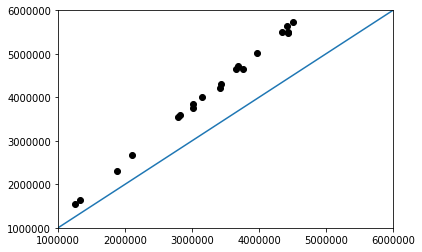

In [25]:
print len(guide_counts_counter_dict[guide_counts_counter_dict.keys()[0]])
print guide_counts_counter_dict.keys()[0]
print len(guide_counts_counter_dict_v1[guide_counts_counter_dict_v1.keys()[0]])
print guide_counts_counter_dict_v1.keys()[0]


plt.plot([sum(guide_counts_counter_dict[x].values()) for x in lib_index_tuble_dict.keys()], [sum(guide_counts_counter_dict_v1[x].values()) for x in lib_index_tuble_dict.keys()], 'ko')
plt.xlim(1000000, 6000000)
plt.ylim(1000000, 6000000)
plt.plot(range(1000000,6000000), range(1000000,6000000))
print '        slope          intercept          r_value              p_value                  std_err'
print scipy.stats.linregress([sum(guide_counts_counter_dict[x].values()) for x in lib_index_tuble_dict.keys()], [sum(guide_counts_counter_dict_v1[x].values()) for x in lib_index_tuble_dict.keys()])
print 0.9989602715722948**2

In [26]:
# Sum guides counts across libraries to make mutation frequency analysis easier

guide_total_counts_v0 = {}
guide_total_counts_v1 = {}

for guide in guide_list:
    
    guide_total_counts_v0[guide] = 0
    guide_total_counts_v1[guide] = 0
    
# create empty dicts to hold the values, and then create an entry for each guide with a count of 0
    
for lib in lib_index_tuble_dict.keys():
    # loops through every library
    
    for guide in guide_list:
        # loops through every guide
        
        guide_total_counts_v0[guide] += guide_counts_counter_dict[lib][guide]
        guide_total_counts_v1[guide] += guide_counts_counter_dict_v1[lib][guide]
        # adds the number of counts fot a guide in a specific library to the total across all libraries
    
    

        slope          intercept          r_value              p_value                  std_err
(1.1763520173164752, 133.99751890926336, 0.9671565857661126, 0.0, 0.0015462668825918743)


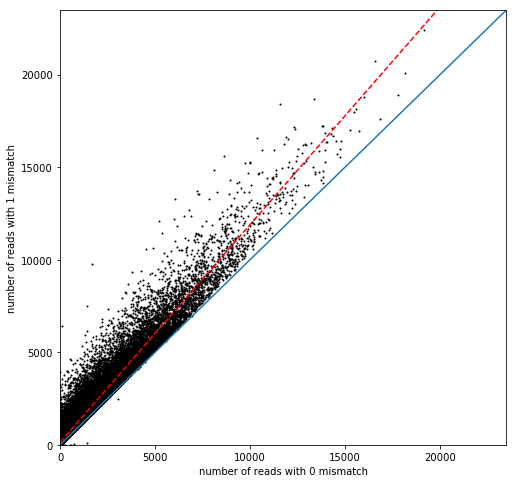

In [11]:
plt.figure(figsize=(8,8))

ax = [x for x in range(0,25000)]
ay = [((x*1.17635)+ 134) for x in range(0,25000)]
# plot a 1:1 relation, and then the regression


plt.plot([x for x in guide_total_counts_v0.values()], [x for x in guide_total_counts_v1.values()], 'ko', ms =1)
plt.xlabel('number of reads with 0 mismatch')
plt.ylabel('number of reads with 1 mismatch')
plt.xlim(0,23500)
plt.ylim(0,23500)

plt.plot(range(0,25000), range(0,25000))
print '        slope          intercept          r_value              p_value                  std_err'
print scipy.stats.linregress([x for x in guide_total_counts_v0.values()], [x for x in guide_total_counts_v1.values()])

plt.plot(ax,ay,'r--')

A lots of outliers, removing then will probably bring down the slope of the regression but will also both increase the r-values and reduce the std error

## Make a Dataframe from the data

In [ ]:
######## DEPRECATED WAS USED BEFORE ERROR CORRECTED DATA WAS AVAILABLE

df_counts_including_0_counts_v0 = {}
df_proportion_including_0_counts_v0 = {}

df_counts_including_0_counts_v1 = {}
df_proportion_including_0_counts_v1 = {}


for lib in guide_counts_counter_dict:
    
    lib_counts = {}
    
    lib_props = {}
    
    lib_counts_v1 = {}
    
    lib_props_v1 = {}
    
    for guide in guide_list:
        
        lib_counts[guide] = guide_counts_counter_dict[lib][guide]
        lib_counts_v1[guide] = guide_counts_counter_dict_v1[lib][guide]
        
        # counts per guide for library
        
        
    lib_total_reads = sum(guide_counts_counter_dict[lib].values())
    lib_total_reads_v1 = sum(guide_counts_counter_dict_v1[lib].values())
    # sum counts so proportions can be calculated

 
    for guide in guide_list:
        
        prop_guide = float((guide_counts_counter_dict[lib][guide])+1.0)/lib_total_reads
        lib_props[guide] = prop_guide
        
        prop_guide_v1 = float((guide_counts_counter_dict_v1[lib][guide])+1.0)/lib_total_reads_v1
        lib_props_v1[guide] = prop_guide_v1
        
        # add one to counts so log conversion is always possible in downstream analysis
        
    df_counts_including_0_counts_v0[lib] = lib_counts
    df_proportion_including_0_counts_v0[lib] = lib_props
    
    df_counts_including_0_counts_v1[lib] = lib_counts_v1
    df_proportion_including_0_counts_v1[lib] = lib_props_v1
    # add lib dicts to the overarching super dict

        

counts_df = pd.DataFrame.from_dict(df_counts_including_0_counts_v0, orient = 'columns')
props_df = pd.DataFrame.from_dict(df_proportion_including_0_counts_v0, orient ='columns')

counts_df_v1 = pd.DataFrame.from_dict(df_counts_including_0_counts_v1, orient = 'columns')
props_df_v1 = pd.DataFrame.from_dict(df_proportion_including_0_counts_v1, orient ='columns')
# convert superdicts to dataframes


#print counts_df.head(10)
#print props_df.head(10)

#print counts_df_v1.head(10)
#print props_df_v1.head(10)

#counts_df.to_csv('./full_guide_counts.csv')
#props_df.to_csv('./full_guide_props.csv')

counts_df_v1.to_csv('./full_guide_counts_v1.csv')
props_df_v1.to_csv('./full_guide_props_v1.csv')

(0, 0.0006)

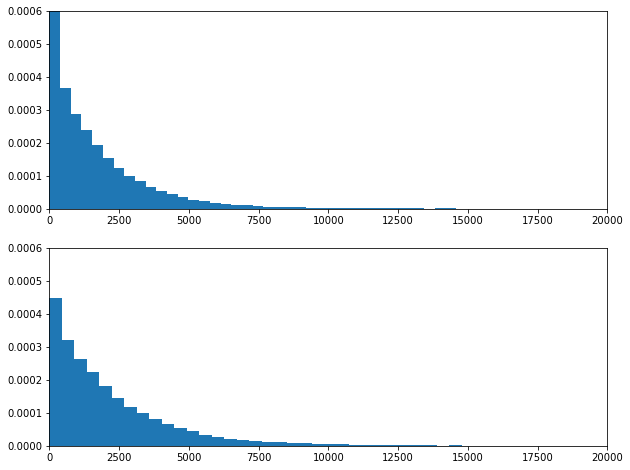

In [13]:
count_sum_v0 = [sum(counts_df.loc[x]) for x in counts_df.index]
count_sum_v1 = [sum(counts_df_v1.loc[x]) for x in counts_df_v1.index if sum(counts_df_v1.loc[x]) > 0]


plt.figure(figsize=(10,8))
plt.subplot(211)
plt.hist(count_sum_v0, bins = 50, density=True)
plt.xlim(0,20000)
plt.ylim(0,0.0006)

plt.subplot(212)
plt.hist(count_sum_v1, bins = 50, density=True)
plt.xlim(0,20000)
plt.ylim(0,0.0006)



2450.0 1.1003504147814513 0.0


(0, 3)

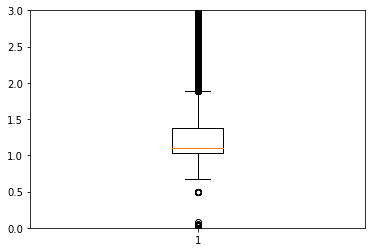

In [14]:
both_v0_and_v1 = set(counts_df.index) & set(counts_df_v1.index)

diff_v1_v0 = [((sum(counts_df_v1.loc[x]))/(sum(counts_df.loc[x])+1.0)) for x in both_v0_and_v1]

print max(diff_v1_v0), np.median(diff_v1_v0), min(diff_v1_v0)

plt.boxplot(diff_v1_v0)
plt.ylim(0,3)

7635
591
['chrIII_110248r', 'chrIII_131077r', 'chrIII_137929', 'chrIII_210916', 'chrIII_210940r', 'chrIII_215700r', 'chrIII_219487', 'chrIII_221146', 'chrIII_222399', 'chrIII_23346r']


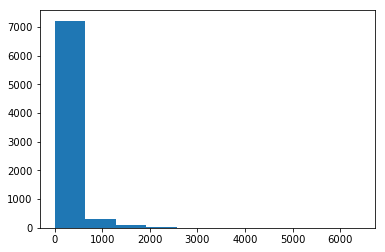

In [15]:
from_near_0 = [x for x in counts_df.index if sum(counts_df.loc[x]) < 200]
print len(from_near_0)

plt.hist([sum(counts_df_v1.loc[x]) for x in from_near_0 if x in both_v0_and_v1])

to_over_1000 = [x for x in from_near_0 if sum(counts_df_v1.loc[x]) >= 500]
print len(to_over_1000)

print to_over_1000[0:10]


## Get a summary of mismatches across all libraries

In [7]:
def count_error_types(guide):
    # build a Counter object for each guide that summarizes the distribution of errors in alignment across all 
    # different timepoints. Takes a guides name (ex.: 'chrIII_110248r') that serves as an index in the chip table 
    # as input
    
    
    guide_mismatch_counter = Counter()
    # the Counter object for the guide
    
    for lib in lib_index_tuble_dict.keys():
        # loops through all the timepoints
    
            mismatch_pattern = guide_mismatch_dict[lib][guide]
            # gets the list of mismatch patterns for that guide a at a specific timepoint
            #print lib, mismatch_pattern
            # deprecated (for debug)

            for x in mismatch_pattern:
                # loops through the mismatch patterns stored as list

                if x == []:                   
                    guide_mismatch_counter['ok'] += 1
                    # if the object is an empty list, the alignment was perfect. Add one to the perfect alignment 
                    # count, which will have 'ok' as a key.

                else:
                    guide_mismatch_counter[x] += 1
                    # else add one to the count of that specific mismatch. The mismatch as outputed by bowtie will
                    # serve as key


    return guide_mismatch_counter
    # returns the mismatch counter for the guide

#print sorted(count_error_types('chrIII_110248r').values(), reverse=True)



In [8]:
all_guides_error_counter_dict = {}

for guide in guide_list:
    
    all_guides_error_counter_dict[guide] = count_error_types(guide)
    
print all_guides_error_counter_dict['chrIV_1020983']

Counter({'ok': 3566, '3:T>C': 518, '15:T>C': 115, '2:T>C': 17, '7:C>A': 6, '1:C>A': 5, '16:C>A': 5, '4:C>A': 5, '22:G>T': 4, '1:C>T': 4, '14:T>C': 4, '5:T>G': 4, '9:G>T': 4, '0:T>A': 3, '18:C>T': 3, '14:A>T': 3, '6:A>T': 3, '2:A>T': 2, '22:G>A': 2, '16:C>G': 2, '12:A>C': 2, '6:A>C': 2, '19:C>T': 2, '17:T>C': 2, '12:A>T': 2, '18:C>G': 2, '18:C>A': 2, '11:A>T': 2, '9:G>C': 2, '5:T>A': 2, '5:T>C': 2, '7:C>G': 2, '19:C>A': 2, '23:T>G': 2, '7:C>T': 2, '20:T>A': 1, '20:T>C': 1, '16:C>T': 1, '0:T>G': 1, '2:A>C': 1, '12:A>G': 1, '23:T>A': 1, '6:A>G': 1, '14:A>G': 1, '1:T>C': 1, '11:A>G': 1, '4:C>G': 1, '10:A>C': 1, '4:C>T': 1, '3:T>G': 1, '10:A>G': 1, '3:T>A': 1, '23:T>C': 1, '0:T>C': 1, '13:T>C': 1})


# evaluate biases in errors

In [9]:
mut_pos_heat_dict_for_df = {}
# super dict that will be used to store rows

mut_pos = range(0,24)
# the number of nt in the sequence selected for alignment

for x in mut_pos:
    
    mut_pos_heat_dict_for_df[x] = Counter()
    # loop through error position and create a counter for each position
    
for x in guide_mismatch_dict.keys():
       
    for y in guide_mismatch_dict[x]:
        # loops trhough all guides in all libs
        
        for z in guide_mismatch_dict[x][y]:
        
            if z != []:
                # loops trhough error entries and skip empty ones

                info = z.split(':')
                error_pos = int(info[0])
                error_type = info[1]
                # split error info in two and extract both the error positions ans the error itself

                mut_pos_heat_dict_for_df[error_pos][error_type] += 1
                # increase the count for a specifi error at a specific position in the guide by one


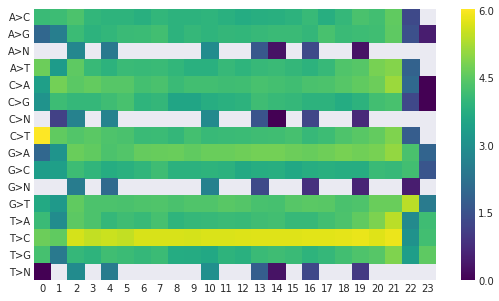

In [10]:
mut_pos_heat_df = pd.DataFrame.from_dict(mut_pos_heat_dict_for_df).apply(np.log10)

plt.figure(figsize = (9,5))

with sns.axes_style('dark'):
    sns.heatmap(mut_pos_heat_df, cmap = 'viridis', mask=mut_pos_heat_df.isnull())

In [29]:

patterns_over_threshold = {}
# a dict that will hold the mismatch patterns over the relative abundance threshold vs the 0 mismatch read for all guides

all_guides_error_counter_dict = {}
# a dict that will hold the ouput of the count_error_type function applied to all the guides

for guide in guide_list:
    
    all_guides_error_counter_dict[guide] = count_error_types(guide)
    # loops through every count and sums the error and 0-mismatch counts across all libraries.
    
invalid_guides = []
# guides with no 0-mismatch alignments

patterns_as_ref = {}
# guide: pattern dict that holds the mismatch patterns abundant enough to be used as neutral in the abundance analysis

candidates = 0
# number of erroneous mismatches that fit the criteria


######## this part calculates error rates based on mutation patterns of guides across the whole library
for guide, counter in all_guides_error_counter_dict.iteritems():
    
    #if guide == 'chrIV_1020983':
        # deprecated, used for qc

    ok_count = counter['ok']

    patterns_over_threshold_list = []
    
    patterns_as_ref_list = []

    if ok_count != 0:

        for pattern, count in counter.iteritems():

            if pattern != 'ok':

                if count*1.0/ok_count > 0.075:

                    patterns_over_threshold_list.append(pattern)
                    
                    if count >= 1000:
                        
                        pattern_info = pattern.split(':')
                        
                        if int(pattern_info[0]) in [14,15,16,17,18,19,20]:

                            candidates += 1
                            patterns_as_ref_list.append(pattern)

                    
    if ok_count == 0:
        
        invalid_guides.append(guide)
        
        for pattern, count in counter.iteritems():
        
            if count >= 1000:
                        
                pattern_info = pattern.split(':')

                if int(pattern_info[0]) in [14,15,16,17,18,19,20]:

                    candidates += 1
                    patterns_as_ref_list.append(pattern)

        
    patterns_as_ref[guide] = patterns_as_ref_list
    patterns_over_threshold[guide] = patterns_over_threshold_list

        
print patterns_over_threshold['chrIV_1020983']
print patterns_over_threshold.values()[0:15]
print candidates

['3:T>C']
[['12:T>C'], [], [], [], [], [], [], [], [], ['16:A>T'], [], ['2:A>C', '5:T>C'], ['16:T>C', '3:T>C'], [], []]
1032


In [30]:
print patterns_as_ref.items()[0:10]

[('chrII_230082', []), ('chrVII_321800', []), ('chrXV_565000r', []), ('chrIII_222226r', []), ('chrIV_609529r', []), ('chrXIV_701982r', []), ('chrIV_490093', []), ('chrIV_129169', []), ('chrXIV_199720r', []), ('chrVII_514873r', [])]


In [31]:
print len(guide_mismatch_dict['gal_16_B']['chrIV_1020983'])


cnt = Counter()

for x in guide_mismatch_dict['gal_16_B']['chrIV_1020983']:
    
    
    cnt[str(x)] += 1
    
print cnt




140
Counter({'[]': 117, '3:T>C': 17, '15:T>C': 3, '20:T>A': 1, '2:T>C': 1, '9:G>T': 1})


In [ ]:
guide_count_copy = {}


for x in lib_index_tuble_dict.keys():
    
    guide_count_copy[x] = {}
    

    
print guide_count_copy.keys()

guide_counts_removed = []

for lib in guide_count_copy.keys():
    
    for guide in guide_list:
    

        original_count = guide_counts_counter_dict_v1[lib][guide]

       
        number_of_counts_to_to_be_removed = 0
        pattern_count = 0
        
        if patterns_over_threshold[guide] != []:
            
            if patterns_as_ref[guide] != []:
                
                abundant_patterns = patterns_as_ref[guide]
                
                for mutation in abundant_patterns:
                    
                    new_guide_name = guide+'|'+mutation
                    
                    guide_count_copy[lib][new_guide_name] = guide_mismatch_dict[lib][guide].count(mutation)
                
            
            for pattern in patterns_over_threshold[guide]:
                
                pattern_count = guide_mismatch_dict[lib][guide].count(pattern)

                number_of_counts_to_to_be_removed = number_of_counts_to_to_be_removed + pattern_count


            guide_count_copy[lib][guide] = original_count - number_of_counts_to_to_be_removed
            
            
        elif guide in invalid_guides:
            guide_count_copy[lib][guide] = 0
            
            if patterns_as_ref[guide] != []:
                
                abundant_patterns = patterns_as_ref[guide]
                
                for mutation in abundant_patterns:
                    
                    new_guide_name = guide+'|'+mutation
                    
                    guide_count_copy[lib][new_guide_name] = guide_mismatch_dict[lib][guide].count(mutation)

        else:
            guide_count_copy[lib][guide] = original_count
            

        guide_counts_removed.append(number_of_counts_to_to_be_removed)

        if len(guide_counts_removed) % 200000 == 0:

            print len(guide_counts_removed)
            print time.now()



print guide_count_copy['gal_16_B']['chrIV_1020983']
print guide_counts_counter_dict_v1['gal_16_B']['chrIV_1020983']
print guide_counts_counter_dict['gal_16_B']['chrIV_1020983']

In [33]:
print len(guide_count_copy['gal_16_B'].keys())

41010


In [34]:
a = [1,1,1,1,1,2,3,3,3]
a.count(1)

5

In [35]:
sum(guide_counts_removed)

11914239

(array([7.81231e+05, 1.58620e+04, 1.98300e+03, 3.64000e+02, 7.20000e+01,
        2.70000e+01, 1.20000e+01, 6.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([   0.,  123.,  246.,  369.,  492.,  615.,  738.,  861.,  984.,
        1107., 1230.]),
 <a list of 10 Patch objects>)

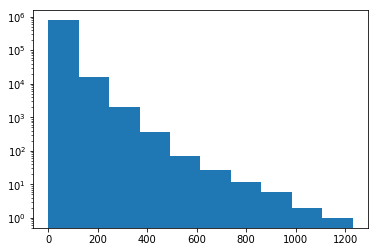

In [36]:
plt.hist(guide_counts_removed, log=True)

(array([2.8819e+04, 7.5160e+03, 2.3700e+03, 7.8400e+02, 3.2400e+02,
        9.2000e+01, 5.0000e+01, 1.7000e+01, 5.0000e+00, 1.0000e+00]),
 array([    0. ,  2238.9,  4477.8,  6716.7,  8955.6, 11194.5, 13433.4,
        15672.3, 17911.2, 20150.1, 22389. ]),
 <a list of 10 Patch objects>)

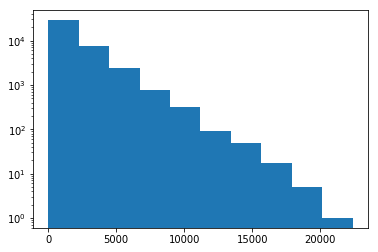

In [37]:
improved_v1_counts = Counter()

for lib in guide_count_copy.keys():
    
    for guide in guide_list:
        improved_v1_counts[guide] += guide_count_copy[lib][guide]
        
len(improved_v1_counts)
len(guide_total_counts_v1.values())

plt.hist(improved_v1_counts.values(), log=True)

LinregressResult(slope=1.097398431316117, intercept=-38.14750079084661, rvalue=0.9980669051929331, pvalue=0.0, stderr=0.0003417720961754421)


<Figure size 576x576 with 0 Axes>

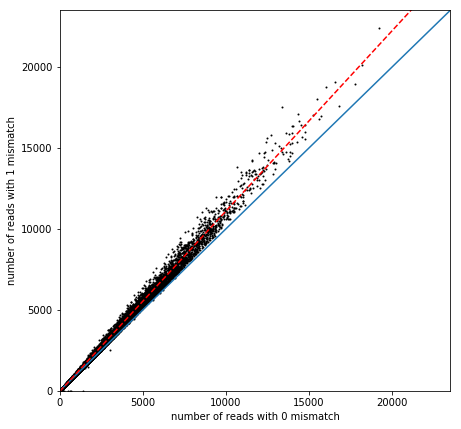

In [38]:
plt.figure(figsize = (8,8))

ax = [x for x in range(0,25000)]
ay = [((x*1.1138094) -39) for x in range(0,25000)]

plt.figure(figsize = (7,7))


plt.plot([x for x in guide_total_counts_v0.values()], [x for x in improved_v1_counts.values()], 'ko', ms =1)
plt.xlabel('number of reads with 0 mismatch')
plt.ylabel('number of reads with 1 mismatch')
plt.xlim(0,23500)
plt.ylim(0,23500)

plt.plot(range(0,25000), range(0,25000))
#print '        slope          intercept          r_value              p_value                  std_err'
print scipy.stats.linregress([x for x in guide_total_counts_v0.values()], [x for x in improved_v1_counts.values()])

plt.plot(ax,ay,'r--')

In [ ]:
# regression stats based on diff thresholds:
# 0.25  (1.1713450856519316, -44.941691634421204, 0.9905388223794764, 0.0, 0.0008116552722715116)
# 0.20  (1.1585136255972484, -49.040881778334324, 0.9927578364849166, 0.0, 0.0007011639513566459)
# 0.15  (1.1408957656081873, -49.83820108374789, 0.9948688229896478, 0.0, 0.0005802914192094174)
# 0.10  (1.1154147843434998, -45.320058557949096, 0.9969554145303963, 0.0, 0.0004363241601926746)
# 0.075 (1.0973984313160996, -38.14750079081841, 0.9980669051929439, 0.0, 0.00034177209617447025)
# 0.05  (1.0773149385749812, -28.70347189101767, 0.9989784645879147, 0.0, 0.00024373486579271818)
# 0.025 (1.0520480474341376, -12.720867167404322, 0.9997194920196643, 0.0, 0.00012465649087051216)

In [ ]:
df_counts_v1_corr = {}
df_proportion_v1_corr = {}


for lib in lib_index_tuble_dict.keys():

    lib_counts_v1_corr = {}
    
    lib_props_v1_corr = {}
    
    for guide in guide_count_copy[lib].keys():
        
        lib_counts_v1_corr[guide] = guide_count_copy[lib][guide]
        
        
        
    lib_total_reads = sum(guide_count_copy[lib].values())
 
    for guide in guide_count_copy[lib].keys():
        
        prop_guide = float((guide_count_copy[lib][guide])+1.0)/lib_total_reads
        lib_props_v1_corr[guide] = prop_guide
        
        
    df_counts_v1_corr[lib] = lib_counts_v1_corr
    df_proportion_v1_corr[lib] = lib_props_v1_corr


counts_v1_corr = pd.DataFrame.from_dict(df_counts_v1_corr, orient = 'columns')
proportion_v1_corr = pd.DataFrame.from_dict(df_proportion_v1_corr, orient ='columns')

In [ ]:
counts_v1_corr.loc['chrIII_110248r|20:C>T']


In [ ]:
counts_v1_corr.to_csv('./full_guide_counts_v1_corr.csv')
proportion_v1_corr.to_csv('./full_guide_props_v1_corr.csv')